In [1]:
library(nichenetr)

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
setwd('~/stereoseq/20240502-SPACseq/')
lr_network <- readRDS('./RNA/nichenet/lr_network_mouse_21122021.rds')
ligand_target_matrix <- readRDS('./RNA/nichenet/ligand_target_matrix_nsga2r_final_mouse.rds')
weight_network <- readRDS('./RNA/nichenet/weighted_networks_nsga2r_final_mouse.rds')

lr_network <- lr_network %>% distinct(from, to)
head(lr_network)

from,to
<chr>,<chr>
2300002M23Rik,Ddr1
2610528A11Rik,Gpr15
9530003J23Rik,Itgal
a,Atrn
a,F11r
a,Mc1r


In [4]:
setwd('~/stereoseq/20240502-SPACseq/')
df <- read_csv('./plots/cluster_lr.csv', col_names = TRUE)
head(df)

Rows: 168 Columns: 19602
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr     (1): annotations
dbl (19601): 0610005C13Rik, 0610009B22Rik, 0610009O20Rik, 0610010F05Rik, 061...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


0610005C13Rik,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,⋯,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd5,mt-Nd6,annotations,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,DC,0


In [5]:
cdf <- df
cdf$cluster <- rep(0:11, 14)

cdf$sample <- paste(cdf$annotations, cdf$cluster, sep = "_")
row.names(cdf) <- cdf$sample

cdf <- t(cdf)
row.names(cdf) <- convert_alias_to_symbols(row.names(cdf), 'mouse', verbose=TRUE)

cdf <- cdf[1:(nrow(cdf) - 3), ]

sinfo <- data.frame(sample = colnames(cdf))
sinfo$cluster <- sub(".*_", "", sinfo$sample)

Warning message:
“Setting row names on a tibble is deprecated.”


[1] "there are provided symbols that are not in the alias annotation table: "
   [1] "1810049J17Rik"  "2510046G10Rik"  "2900097C17Rik"  "3110021N24Rik" 
   [5] "A530084C06Rik"  "AC061963.1"     "AC079680.1"     "AC084822.2"    
   [9] "AC100400.1"     "AC102103.1"     "AC102334.1"     "AC102815.1"    
  [13] "AC104325.1"     "AC109617.1"     "AC110166.1"     "AC110166.2"    
  [17] "AC110211.1"     "AC112943.2"     "AC113595.1"     "AC114585.1"    
  [21] "AC116487.2"     "AC117197.3"     "AC117608.1"     "AC117662.4"    
  [25] "AC117775.1"     "AC118008.1"     "AC118475.1"     "AC119264.1"    
  [29] "AC121788.1"     "AC122392.2"     "AC122413.1"     "AC122413.2"    
  [33] "AC122551.1"     "AC123059.1"     "AC123724.1"     "AC123870.1"    
  [37] "AC124097.1"     "AC124490.1"     "AC124555.1"     "AC124561.1"    
  [41] "AC124739.1"     "AC124739.2"     "AC125141.3"     "AC125149.3"    
  [45] "AC125199.2"     "AC125455.1"     "AC126055.1"     "AC126280.1"    
  [49] "AC127341.3"   

In [6]:
receptors <- lr_network %>% pull(to) %>% unique()
expressed_genes_receiver <- t(cdf[, grepl("T_[0-9]*$", colnames(cdf))]) %>%
    apply(2, function(x){10 * (2^as.numeric(x) - 1)}) %>%
    apply(2, function(x){log2(mean(x) + 1)}) %>%
    .[. >= 500] %>% names()
expressed_receptors <- intersect(receptors, expressed_genes_receiver)
print(c(length(expressed_receptors), 'Cd44' %in% expressed_receptors))

[1] 54  1


In [7]:
ligands <- lr_network %>% pull(from) %>% unique()
expressed_genes_sender <- t(cdf[, grepl("Macrophages_[0-9]*$", colnames(cdf))]) %>%
    apply(2, function(x){10 * (2^as.numeric(x) - 1)}) %>%
    apply(2, function(x){log2(mean(x) + 1)}) %>%
    .[. >= 500] %>% names()
expressed_ligands <- intersect(ligands, expressed_genes_sender)
print(c(length(expressed_ligands), 'Spp1' %in% expressed_ligands))

[1] 119   1


In [8]:
# Only consider genes also present in the NicheNet model - this excludes genes from the gene list for which the official HGNC symbol was not used by Puram et al.
T_marker <- c('Cd8a', 'Cd8b', 'Il7r', 'Cd27', 'Ccr4', 'Eomes', 'Gpr183', 'Cd69', 'Ifng', 'Fgfbp2', 'Gzmh', 'Gzmk', 'Gzma', 'Gzmb', 'Prf1', 'Gnly', 'Nkg7', 'Lag3', 'Pdcd1', 'Tigit', 'Ctla4', 'Tox', 'Sirpg', 'Tnfrsf9', 'Tnfrsf18', 'Cxcr6', 'Cxcl13', 'Tcf7', 'Foxo1')
geneset_oi <- T_marker %>% .[. %in% rownames(ligand_target_matrix)]
length(geneset_oi)

[1] 24

In [9]:
potential_ligands <- lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique()
length(potential_ligands)

[1] 61

In [10]:
background_expressed_genes <- expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]
length(background_expressed_genes)

[1] 1110

In [11]:
ligand_activities <- predict_ligand_activities(geneset = geneset_oi,
                                               background_expressed_genes = background_expressed_genes,
                                               ligand_target_matrix = ligand_target_matrix,
                                               potential_ligands = potential_ligands)
head(ligand_activities)

test_ligand,auroc,aupr,aupr_corrected,pearson
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Adam15,0.4457693,0.02069181,-0.0005471295,-0.010735882
Angptl4,0.5123380,0.03361500,0.0123760629,0.050334791
Apoe,0.4495743,0.02069749,-0.0005414525,-0.007530861
B2m,0.5842563,0.08211986,0.0608809259,0.186008012
C1qb,0.4657738,0.02758884,0.0063499065,0.031090803
C3,0.4738359,0.02390471,0.0026657678,0.004516045


In [12]:
(ligand_activities <- ligand_activities %>% arrange(-aupr_corrected) %>%
  mutate(rank = rank(desc(aupr_corrected))))

best_upstream_ligands <- ligand_activities %>% top_n(30, aupr_corrected) %>%
  arrange(-aupr_corrected) %>% pull(test_ligand)

best_upstream_ligands


test_ligand,auroc,aupr,aupr_corrected,pearson,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H2-K1,0.5655704,0.08250599,0.061267052,0.1845294813,1
B2m,0.5842563,0.08211986,0.060880926,0.1860080122,2
H2-Q7,0.5647792,0.08211884,0.060879905,0.1835377148,3
H2-D1,0.5647416,0.08211735,0.060878407,0.1835191208,4
Cxcl10,0.5215680,0.07042667,0.049187729,0.1098868090,5
Sirpa,0.5606352,0.06797985,0.046740916,0.1841376118,6
Furin,0.5104543,0.06585079,0.044611848,0.0209612084,7
Spp1,0.4533793,0.06232106,0.041082121,0.0935190979,8
Vcam1,0.4501771,0.06174380,0.040504867,0.1507266480,9


[1] "H2-K1"    "B2m"      "H2-Q7"    "H2-D1"    "Cxcl10"   "Sirpa"   
 [7] "Furin"    "Spp1"     "Vcam1"    "Sparc"    "Tgm2"     "Ccl8"    
[13] "Angptl4"  "Gzmb"     "Gzmc"     "Ccl7"     "Ccl2"     "Cd47"    
[19] "Thy1"     "Itgb2"    "Ccl5"     "C1qb"     "H2-DMb1"  "Csf1"    
[25] "S100a4"   "Serping1" "Col16a1"  "Tgfbi"    "Itgb1"    "Timp1"

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message in plot_theme(plot):
“The `plot.width` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.height` theme element is not defined in the element hierarchy.”


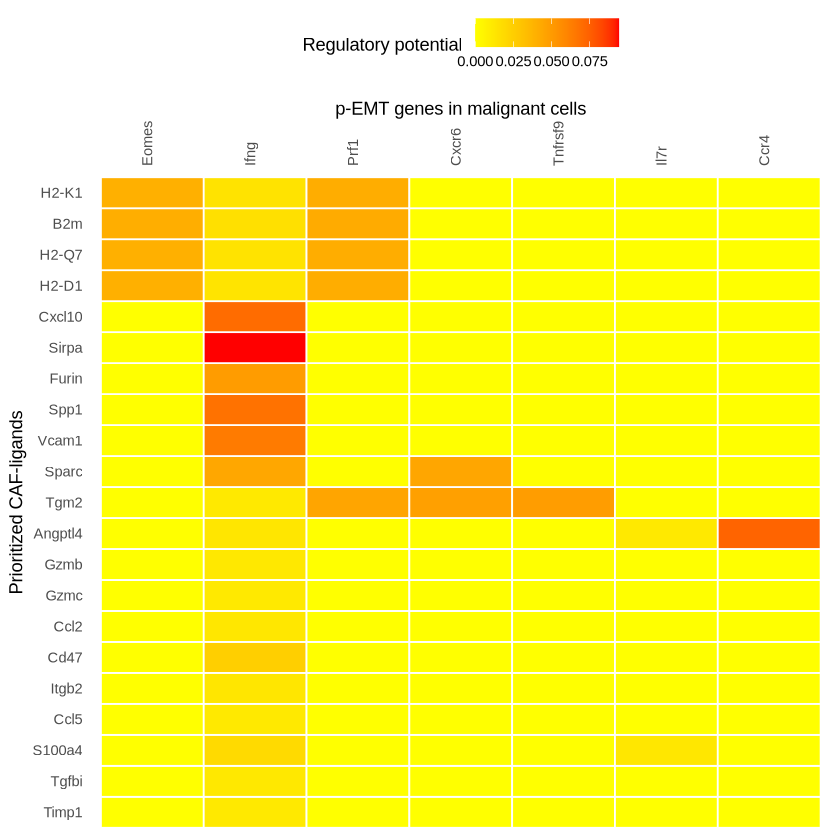

In [13]:
active_ligand_target_links_df <- best_upstream_ligands %>%
  lapply(get_weighted_ligand_target_links,
         geneset = geneset_oi,
         ligand_target_matrix = ligand_target_matrix,
         n = 100) %>% bind_rows()

# 检查是否存在缺失值并处理
if (any(is.na(active_ligand_target_links_df$weight))) {
  active_ligand_target_links_df <- active_ligand_target_links_df %>%
    filter(!is.na(weight))  # 移除缺失值
}

active_ligand_target_links <- prepare_ligand_target_visualization(
  ligand_target_df = active_ligand_target_links_df,
  ligand_target_matrix = ligand_target_matrix,
  cutoff = 0.25)

order_ligands <- intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev()
order_targets <- active_ligand_target_links_df$target %>% unique() %>% intersect(rownames(active_ligand_target_links))

vis_ligand_target <- t(active_ligand_target_links[order_targets, order_ligands])

p_ligand_target_network <- make_heatmap_ggplot(vis_ligand_target, "Prioritized CAF-ligands", "p-EMT genes in malignant cells",
                    color = "orange", legend_title = "Regulatory potential") +
  scale_fill_gradient2(low = "white", mid = "yellow", high = "red", midpoint = 0) +
  theme(plot.width = unit(20, "in"), plot.height = unit(6, "in"))

p_ligand_target_network

Warning message in plot_theme(plot):
“The `plot.width` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.height` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.width` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.height` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.width` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.height` theme element is not defined in the element hierarchy.”


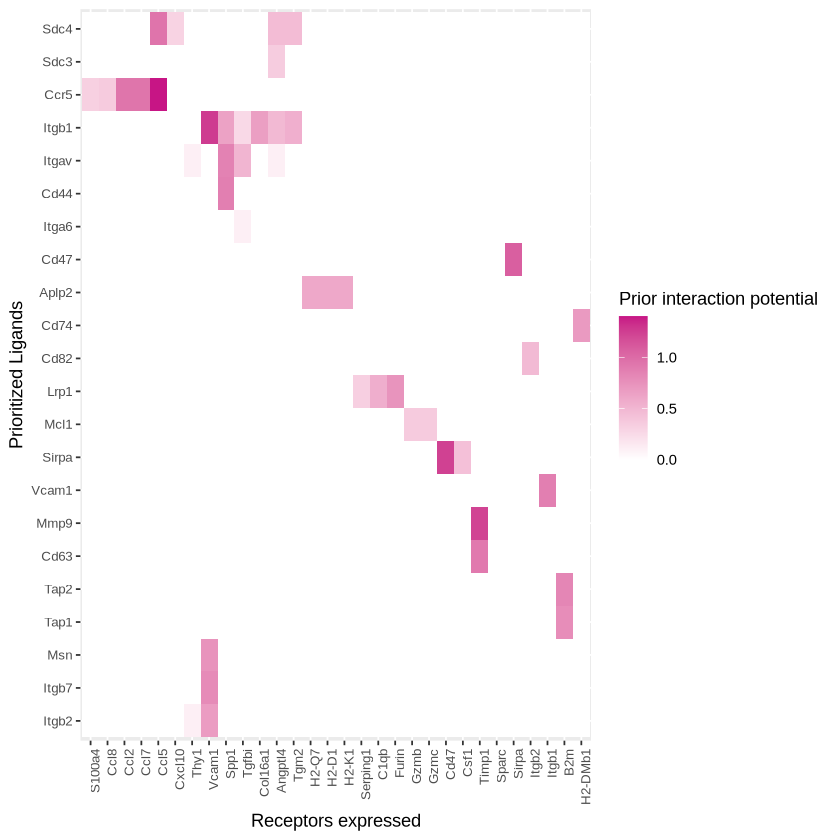

In [14]:
ligand_receptor_links_df <- get_weighted_ligand_receptor_links(
  best_upstream_ligands, expressed_receptors,
  lr_network, weight_network$lr_sig) 

vis_ligand_receptor_network <- prepare_ligand_receptor_visualization(
  ligand_receptor_links_df,
  best_upstream_ligands,
  order_hclust = "both")

# 将 vis_ligand_receptor_network 转换为数据框以便使用 select 和 filter
vis_ligand_receptor_network_df <- as.data.frame(vis_ligand_receptor_network)

vis_ligand_receptor_network_df <- vis_ligand_receptor_network_df %>%
  select(-contains("Wnt")) %>%
  filter(!rownames(vis_ligand_receptor_network_df) %in% grep("F", rownames(vis_ligand_receptor_network_df), value = TRUE)) 

ggplot(data = as.data.frame(as.table(as.matrix(vis_ligand_receptor_network_df))), aes(x = Var2, y = Var1, fill = Freq)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "mediumvioletred") +
  labs(y = "Prioritized Ligands", x = "Receptors expressed", fill = "Prior interaction potential") +
  theme(plot.width = unit(9, "in"), plot.height = unit(9, "in"),
        axis.text.x = element_text(angle = 90, hjust = 1, size = 8),
        axis.text.y = element_text(size=8))  # 调整字体大小，旋转xticks

ggsave('./plots/cluster_lr_ligand_receptor.pdf', width = 12, height = 9, device = 'pdf', dpi = 300)


In [21]:
library(reshape2)
melted_vis_ligand_receptor_network_df <- melt(vis_ligand_receptor_network_df)
melted_vis_ligand_receptor_network_df$source <- rownames(vis_ligand_receptor_network_df)
colnames(melted_vis_ligand_receptor_network_df) <- c("target", "weight", "source")

melted_vis_ligand_receptor_network_df <- melted_vis_ligand_receptor_network_df[c(3, 1, 2)]
print(melted_vis_ligand_receptor_network_df)

No id variables; using all as measure variables



    source   target    weight
1    Itgb2   S100a4 0.0000000
2    Itgb7   S100a4 0.0000000
3      Msn   S100a4 0.0000000
4     Tap1   S100a4 0.0000000
5     Tap2   S100a4 0.0000000
6     Cd63   S100a4 0.0000000
7     Mmp9   S100a4 0.0000000
8    Vcam1   S100a4 0.0000000
9    Sirpa   S100a4 0.0000000
10    Mcl1   S100a4 0.0000000
11    Lrp1   S100a4 0.0000000
12    Cd82   S100a4 0.0000000
13    Cd74   S100a4 0.0000000
14   Aplp2   S100a4 0.0000000
15    Cd47   S100a4 0.0000000
16   Itga6   S100a4 0.0000000
17    Cd44   S100a4 0.0000000
18   Itgav   S100a4 0.0000000
19   Itgb1   S100a4 0.0000000
20    Ccr5   S100a4 0.3284765
21    Sdc3   S100a4 0.0000000
22    Sdc4   S100a4 0.0000000
23   Itgb2     Ccl8 0.0000000
24   Itgb7     Ccl8 0.0000000
25     Msn     Ccl8 0.0000000
26    Tap1     Ccl8 0.0000000
27    Tap2     Ccl8 0.0000000
28    Cd63     Ccl8 0.0000000
29    Mmp9     Ccl8 0.0000000
30   Vcam1     Ccl8 0.0000000
31   Sirpa     Ccl8 0.0000000
32    Mcl1     Ccl8 0.0000000
33    Lrp1

In [28]:
write.csv(melted_vis_ligand_receptor_network_df, './cluster_lr_ligand_receptor_network.csv', row.names = FALSE)


In [27]:
# 使用 flows 数据绘制和弦图
# 改变 flows 中 source 的比例，使得其 node 与 target 的占比是一半一半
source_proportion <- table(melted_vis_ligand_receptor_network_df$source) / sum(table(melted_vis_ligand_receptor_network_df$source))
target_proportion <- table(melted_vis_ligand_receptor_network_df$target) / sum(table(melted_vis_ligand_receptor_network_df$target))

# 确保 source_proportion 和 target_proportion 的名称一致
all_levels <- union(names(source_proportion), names(target_proportion))
source_proportion <- source_proportion[all_levels]
target_proportion <- target_proportion[all_levels]
source_proportion[is.na(source_proportion)] <- 0
target_proportion[is.na(target_proportion)] <- 0

combined_proportion <- (source_proportion + target_proportion) / 2

# 确保 grid_colors 的长度与 flows$source 的唯一值数量一致
grid_colors <- RColorBrewer::brewer.pal(n = min(length(unique(melted_vis_ligand_receptor_network_df$source)), 11), name = "RdBu")
# 使用 colorRamp 函数来定义边的颜色
# 确保 breaks 的长度与 colors 的长度一致
breaks <- seq(min(melted_vis_ligand_receptor_network_df$weight), max(melted_vis_ligand_receptor_network_df$weight), length.out = 11)
edge_colors <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "RdBu")))(length(breaks) - 1)

library(circlize)

# 绘制和弦图，使用箭头表示边，并增加 source 和 target 之间的间隔
setwd('~/stereoseq/20240502-SPACseq/')
pdf(file = "./chord_diagram.pdf", width = 8, height = 8)
circlize::chordDiagram(melted_vis_ligand_receptor_network_df, transparency = 0.7, annotationTrack = "grid", preAllocateTracks = list(track.height = 0.1),
             col = edge_colors[findInterval(melted_vis_ligand_receptor_network_df$weight, breaks)], directional = 1, direction.type = "arrows", link.arr.type = "big.arrow")
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  sector.name <- get.cell.meta.data("sector.index")
  circos.text(CELL_META$xcenter, CELL_META$ylim[1] + mm_y(5), sector.name, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
}, bg.border = NA)
dev.off()

pdf 
  2

In [19]:
setNames(grid_colors, levels(melted_vis_ligand_receptor_network_df$source)[1:length(grid_colors)]

ERROR: Error in parse(text = input): <text>:2:0: unexpected end of input
1: setNames(grid_colors, levels(melted_vis_ligand_receptor_network_df$source)[1:length(grid_colors)]
   ^
